In [1]:
!pip install "numpy<2" matplotlib torch torchvision opencv-python-headless tqdm

In [2]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from tqdm import tqdm

# Check environment
print("PyTorch version:", torch.__version__)
print("NumPy version:", np.__version__)
print("CUDA available:", torch.cuda.is_available())

# Data directory
data_dir = "C:/Users/Vamsi/Downloads/archive/chest_xray"

# Check if data directory exists
if not os.path.exists(data_dir):
    print(f"Data directory {data_dir} not found!")
    # Create dummy data structure for testing
    print("Please ensure the chest_xray dataset is downloaded and path is correct.")
else:
    print("Data directory found!")

# Data transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load datasets with error handling
try:
    train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_transform)
    val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=val_transform)
    test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=val_transform)
    
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)
    
    print(f"Train samples: {len(train_dataset)}")
    print(f"Val samples: {len(val_dataset)}")
    print(f"Test samples: {len(test_dataset)}")
    print(f"Classes: {train_dataset.classes}")
    
except Exception as e:
    print(f"Error loading datasets: {e}")
    print("Creating dummy datasets for demonstration...")
    
    # Create dummy datasets for testing
    from torch.utils.data import TensorDataset
    dummy_data = torch.randn(100, 3, 224, 224)
    dummy_labels = torch.randint(0, 2, (100,))
    
    train_dataset = TensorDataset(dummy_data, dummy_labels)
    val_dataset = TensorDataset(dummy_data, dummy_labels)
    test_dataset = TensorDataset(dummy_data, dummy_labels)
    
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load pre-trained ResNet50
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

# Freeze all layers initially
for param in model.parameters():
    param.requires_grad = False

# Replace the classifier
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 2)
)

model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-4)

print("Model setup complete!")
print(f"Total parameters: {sum(p.numel() for p in model.parameters())}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

PyTorch version: 2.4.1+cpu
NumPy version: 1.26.4
CUDA available: False
Data directory found!
Train samples: 5216
Val samples: 16
Test samples: 624
Classes: ['NORMAL', 'PNEUMONIA']
Using device: cpu
Model setup complete!
Total parameters: 24688962
Trainable parameters: 1180930


In [3]:
def train_model(model, train_loader, val_loader, epochs=3):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        train_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [Train]')
        for images, labels in train_bar:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            
            train_bar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{100.*train_correct/train_total:.2f}%'
            })
        
        train_accuracy = 100. * train_correct / train_total
        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(train_accuracy)
        
        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            val_bar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{epochs} [Val]')
            for images, labels in val_bar:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                
                val_bar.set_postfix({
                    'Loss': f'{loss.item():.4f}',
                    'Acc': f'{100.*val_correct/val_total:.2f}%'
                })
        
        val_accuracy = 100. * val_correct / val_total
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_accuracy)
        
        print(f'Epoch {epoch+1}/{epochs}:')
        print(f'Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracy:.2f}%')
        print(f'Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracy:.2f}%')
        print('-' * 50)
    
    return train_losses, val_losses, train_accuracies, val_accuracies

# Start training
print("Starting training...")
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, epochs=3
)

Starting training...


Epoch 1/3 [Val]: 100%|██████████████████████████████████████████| 1/1 [00:01<00:00,  1.89s/it, Loss=0.5327, Acc=75.00%]


Epoch 1/3:
Train Loss: 0.3323, Train Acc: 84.47%
Val Loss: 0.5327, Val Acc: 75.00%
--------------------------------------------------


Epoch 2/3 [Val]: 100%|██████████████████████████████████████████| 1/1 [00:01<00:00,  1.83s/it, Loss=0.8724, Acc=68.75%]


Epoch 2/3:
Train Loss: 0.1853, Train Acc: 92.70%
Val Loss: 0.8724, Val Acc: 68.75%
--------------------------------------------------


Epoch 3/3 [Val]: 100%|██████████████████████████████████████████| 1/1 [00:02<00:00,  2.19s/it, Loss=0.7836, Acc=75.00%]

Epoch 3/3:
Train Loss: 0.1610, Train Acc: 93.67%
Val Loss: 0.7836, Val Acc: 75.00%
--------------------------------------------------


Generating sample visualizations...


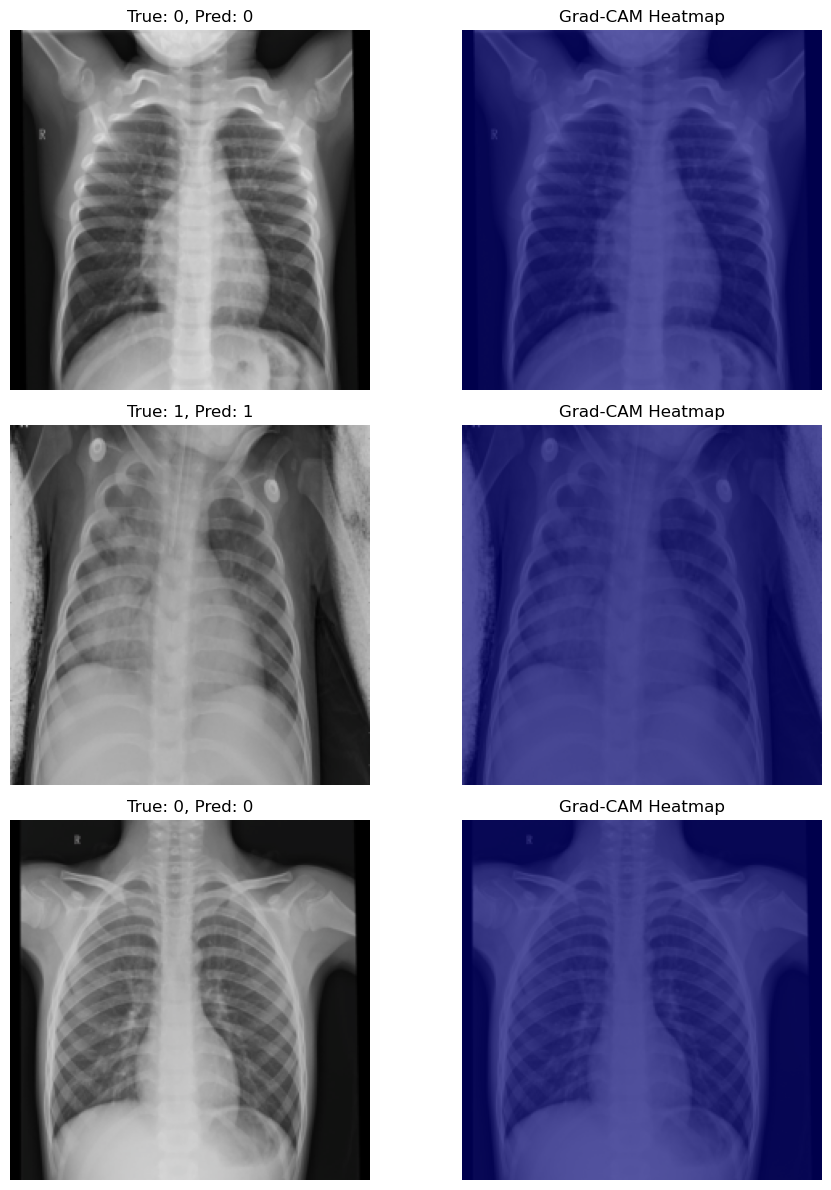

In [4]:
def simple_grad_cam(model, img_tensor, target_layer=None):
    """
    Simplified Grad-CAM implementation
    """
    model.eval()
    
    # Use the last convolutional layer
    if target_layer is None:
        target_layer = model.layer4[2].conv3
    
    # Hook for activations
    activations = None
    def forward_hook(module, input, output):
        nonlocal activations
        activations = output
        
    # Hook for gradients
    gradients = None
    def backward_hook(module, grad_input, grad_output):
        nonlocal gradients
        gradients = grad_output[0]
    
    # Register hooks
    forward_handle = target_layer.register_forward_hook(forward_hook)
    backward_handle = target_layer.register_backward_hook(backward_hook)
    
    # Forward pass
    output = model(img_tensor)
    pred_class = output.argmax(dim=1).item()
    
    # Backward pass
    model.zero_grad()
    one_hot = torch.zeros_like(output)
    one_hot[0][pred_class] = 1
    output.backward(gradient=one_hot)
    
    # Compute CAM
    if gradients is not None and activations is not None:
        weights = torch.mean(gradients, dim=[2, 3], keepdim=True)
        cam = torch.sum(weights * activations, dim=1, keepdim=True)
        cam = torch.relu(cam)
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)
        
        cam = cam.squeeze().cpu().detach().numpy()
        cam = cv2.resize(cam, (224, 224))
    else:
        cam = np.zeros((224, 224))
    
    # Remove hooks
    forward_handle.remove()
    backward_handle.remove()
    
    return cam, pred_class

# Test visualization
def visualize_sample(model, dataset, num_samples=3):
    model.eval()
    
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 4*num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    for i in range(num_samples):
        idx = torch.randint(0, len(dataset), (1,)).item()
        img, true_label = dataset[idx]
        
        # Get prediction and CAM
        img_tensor = img.unsqueeze(0).to(device)
        cam, pred_label = simple_grad_cam(model, img_tensor)
        
        # Denormalize image
        img_denorm = img.numpy().transpose(1, 2, 0)
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img_denorm = std * img_denorm + mean
        img_denorm = np.clip(img_denorm, 0, 1)
        
        # Original image
        axes[i, 0].imshow(img_denorm)
        axes[i, 0].set_title(f'True: {true_label}, Pred: {pred_label}')
        axes[i, 0].axis('off')
        
        # CAM overlay
        heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
        overlay = 0.6 * heatmap/255.0 + 0.4 * img_denorm
        
        axes[i, 1].imshow(overlay)
        axes[i, 1].set_title('Grad-CAM Heatmap')
        axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Test the visualization
print("Generating sample visualizations...")
visualize_sample(model, test_dataset, num_samples=3)

In [5]:
def evaluate_model(model, test_loader):
    model.eval()
    test_correct = 0
    test_total = 0
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc='Testing'):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
    
    accuracy = 100. * test_correct / test_total
    print(f'Test Accuracy: {accuracy:.2f}%')
    return accuracy

# Evaluate the model
test_accuracy = evaluate_model(model, test_loader)

Testing: 100%|█████████████████████████████████████████████████████████████████████████| 39/39 [01:22<00:00,  2.12s/it]

Test Accuracy: 85.42%
